"Сравнительный анализ пабликов, посвящённых мультипликации"

1. Выбрать два крупных сообщества, посвященных анимации
https://vk.com/artanimation
https://vk.com/animatron
2. Проанализировать демографические показатели участников сообщества (гендерное распределение, возраст, географическое положение)
3. Проанализировать частоту и содержание постов в пабликах
4. Выявить различия и сходства между данными показателями в разных сообществах
5. Визуализировать результаты

In [1]:
from collections import Counter
import time
import numpy as np
import matplotlib.pyplot as plt
import vk

def avrg(lst): 
    return sum(lst) / len(lst) 

In [2]:
token = "92ff027f92ff027f92ff027f37928b41d3992ff92ff027fcd8464af6ff92033d0fdf918"  # Сервисный ключ доступа, по завершении дз можно удалить для соблюдения конфиденциальности
session = vk.Session(access_token=token)  # Авторизация
vk_api = vk.API(session)  # Авторизаци

In [3]:
personal_token = "4446dfffdc8c2c0cd0a80141b90fbb055545832e6df0211978cbdab3fb9e62b5a47ef367eabfde168e4b2"  # Персональный ключ доступа, по завершении дз можно удалить для соблюдения конфиденциальности
session = vk.Session(access_token=personal_token)  # Авторизация
vk_personal_api = vk.API(session)  # Авторизация

In [4]:
def get_members(groupid, fields=('sex', 'bdate', 'city', 'country', 'domain')):
    first = vk_api.groups.getMembers(group_id=groupid, fields=fields, v=5.92)  # Первое выполнение метода
    data = first["items"]  # Присваиваем переменной первую тысячу id'шников
    count = first["count"] // 1000  # Присваиваем переменной количество тысяч участников
    # С каждым проходом цикла смещение offset увеличивается на тысячу
    # и еще тысяча id'шников добавляется к нашему списку.
    for i in range(1, count+1):  
        data = data + vk_api.groups.getMembers(group_id=groupid, fields=fields, v=5.92, offset=i*1000)["items"]
    return data

In [5]:
def parse_members_data(members):
    members_data = {
        'sex' : Counter(),
        'bdate' : Counter(),
        'country' : Counter(),
        'city' : Counter()
    }
    for member in members:
        _id = member["id"] # находим айди участника
        first_name = member["first_name"] # находим имя учатника
        last_name = member["last_name"] # находим фамилию учатника
            
        sex = member["sex"] # находим пол учатника (1 или 2)
        if int(sex) == 1:  # если пол это 1 
            sex = "F"  # обозначем женский пол как F
        elif int(sex) == 2:  # если пол это 2 
            sex = "M" # обозначем мужской пол как F
        else:  # если есть другой какой-то пол
            sex = "-"  # скорее всего нет, поэтому ставим прочерк
                
        bdate = member.get('bdate', "-")   # находим день рождения учатника
        if len(bdate.split(".")) == 3:  # нам нужен только год, если он есть
            bdate = bdate.split(".")[-1]  # то сохраняем год
        else:  # если год не указан, то возраст участника мы не узнаем
            bdate = "-"  # поэтому прочерк
                
        city = member.get('city', {}).get("title", "-")  # находим город участника
        country = member.get('country', {}).get("title", "-")  # находим страну участника
        #f.write(f"{_id},\t{first_name}\t{last_name}\t{sex}\t{bdate}\t{city}\t{country}\n")  # сохраняем информацию в файл
        if sex != '-':
            members_data['sex'][sex] +=1
        if bdate != '-' and int(bdate) > 1970:
            members_data['bdate'][bdate] +=1 #round(int(bdate),-1)
        if country != '-':
            members_data['country'][country] +=1
        if city != '-':
            members_data['city'][city] +=1
    return members_data

In [6]:
def parse_posts(posts):
    posts_data = {
        "words_count": [],
        "age": [],
        "date_words": Counter(),
        "symbols_count": [],
    }
    the_time = time.time()
    timelaps = 60*60*24 #  days
    for post in posts:
        posts_data["words_count"].append(len(post["text"].split()))
        posts_data["age"].append(the_time-int(post["date"]))
        posts_data["symbols_count"].append(len(post["text"]))
        posts_data["date_words"][round(posts_data["age"][-1]/timelaps)] = posts_data["words_count"][-1]
    return posts_data

def get_posts(owner_id, limit):
    first = vk_api.wall.get(domain=owner_id, count=100, filter="owner", v=5.124)
    data = first["items"]  # Присваиваем переменной первую тысячу id'шников
    count = first["count"] // 100  # Присваиваем переменной количество тысяч участников
    # С каждым проходом цикла смещение offset увеличивается на тысячу
    # и еще тысяча id'шников добавляется к нашему списку.
    if count > limit: count = limit
    for i in range(1, count+1):  
        data += vk_api.wall.get(domain=owner_id, v=5.124, filter="owner", count=100, offset=i*100)["items"]
    return data

In [7]:
def visualize_counter(counter, width = 6.4, height = 4.8, min_value = 0, topk = 0):
    if topk:
        counter = counter.most_common(topk)
    else:
        counter = sorted(counter.items())
    keys, values = zip(*counter)
    plt.figure(figsize=(width, height))
    plt.bar(keys, values)
    plt.show()
    
def visualize_line(xlabel, ylabel, data, max_days = 100):
    for i in data:
        counter, label = i[0], i[1]
        counter = sorted(counter.items())
        counter = list(filter(lambda x: int(x[0]) < max_days, counter))
        #print(counter, label)
        keys, values = zip(*counter)
        plt.plot(keys, values, label = i[1])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [8]:
%%time
# Запрашиваем членов пабликов
group1 = get_members("artanimation")
group2 = get_members("animatron")

Wall time: 32.6 s


In [9]:
%%time
# Оставляем только нужные данные об этих людях
members1 = parse_members_data(group1)
members2 = parse_members_data(group2)

Wall time: 804 ms


sex


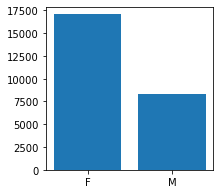

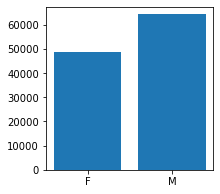

birth date


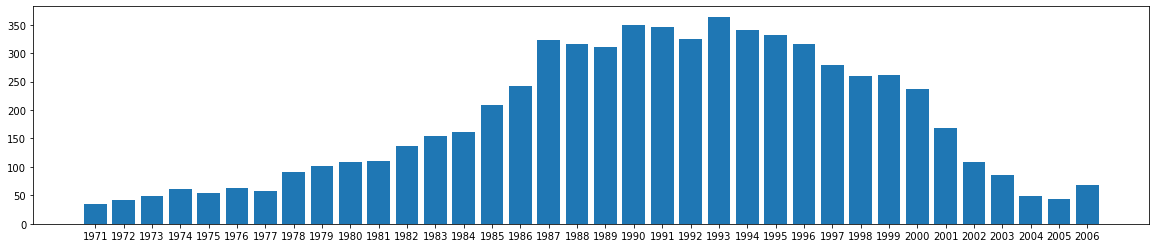

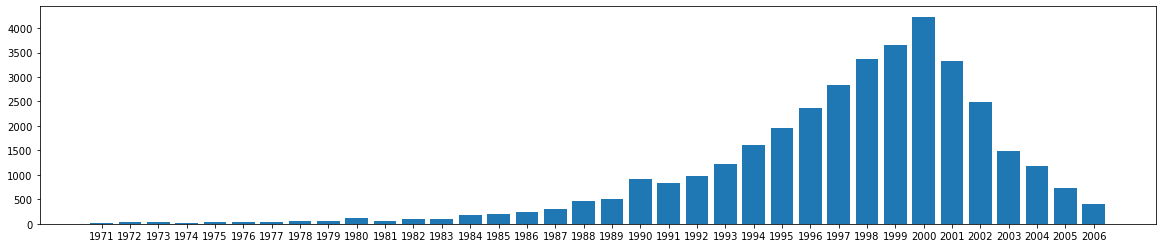

country


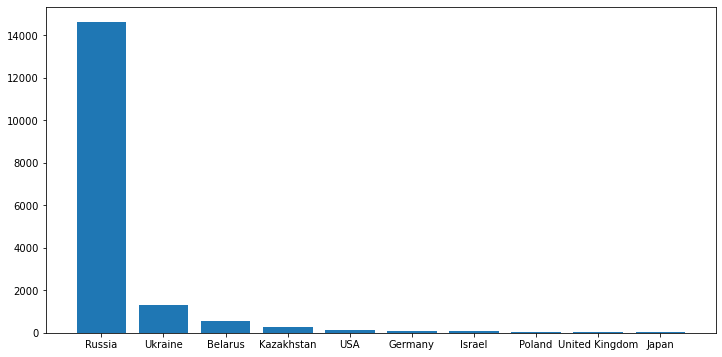

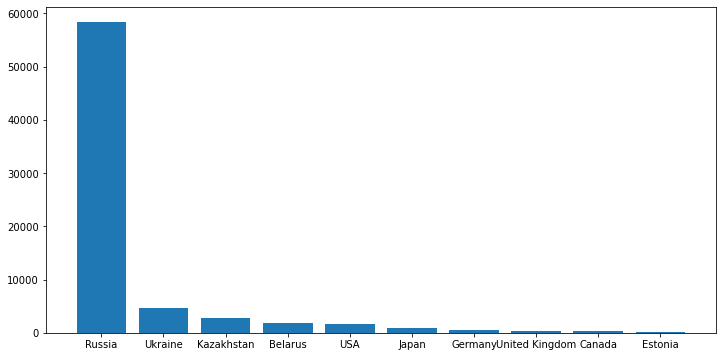

city


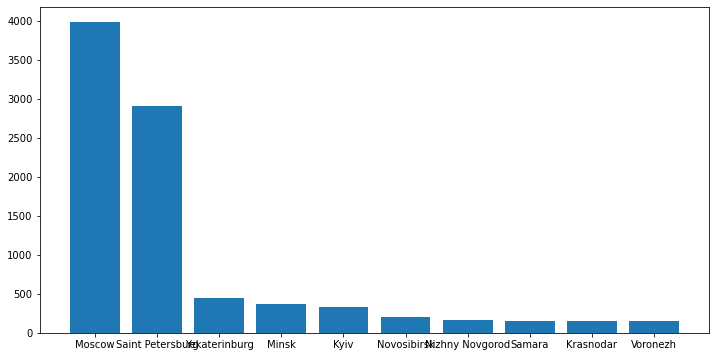

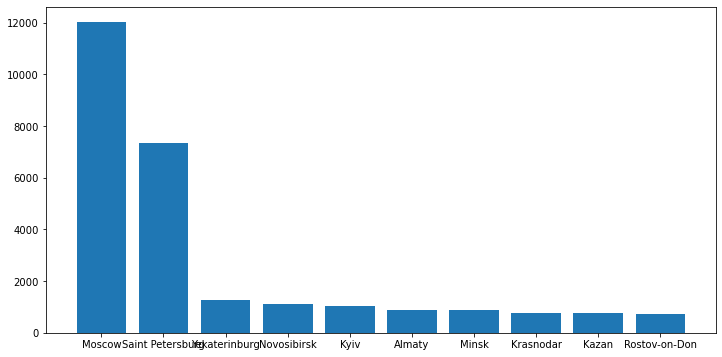

In [10]:
print("sex")
visualize_counter(members1["sex"], width = 3, height = 3)
visualize_counter(members2["sex"], width = 3, height = 3)
print("birth date")
visualize_counter(members1["bdate"], width = 20, height = 4)
visualize_counter(members2["bdate"], width = 20, height = 4)
print("country")
visualize_counter(members1["country"], width = 12, height = 6, topk = 10)
visualize_counter(members2["country"], width = 12, height = 6, topk = 10)
print("city")
visualize_counter(members1["city"], width = 12, height = 6, topk = 10)
visualize_counter(members2["city"], width = 12, height = 6, topk = 10)

In [11]:
%%time
# Получаем посты из сообществ
posts1 = get_posts("artanimation", 1)
posts2 = get_posts("animatron", 3)

Wall time: 4.59 s


In [12]:
# Находим информацию о постах
post1 = parse_posts(posts1)
post2 = parse_posts(posts2)

Average words count per post
artanimation 43.055
animatron 13.235

Posts length vs time


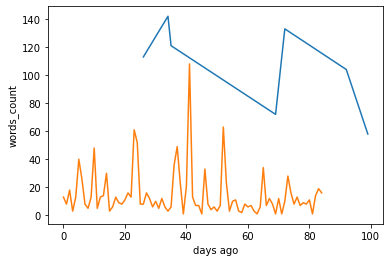

In [13]:
print("Average words count per post")
print("artanimation", avrg(post1["words_count"]))
print("animatron", avrg(post2["words_count"]))
print()
print("Posts length vs time")
visualize_line("days ago", "words_count", [
    [post1["date_words"], "artanimation"], 
    [post2["date_words"], "animatron"]
])